#### This Jupyter Notebook is for modelling purpose
As of now the steps involved in preprocessing of data as below
1. Seperating charge/discharge/impedance cycles in dataframes.
2. Removing consecutive similar charge cycles so as to make charge dataframe similar to discharge dataframe.
3. We will be using charge dataframe for modelling therefore capacity column is concatenated from discharge dataframe to charge dataframe.
4. Also for if classification is required capacity is converted to 4 classes (0 to 3)
5. Divided the data into Train and Test where the Test data is charge cycles for last two battery sets.
6. Removal on nan values from voltage, current, temperature measured column by popping out. (nan occurs in same possition for all the columns, it may be due to BMS inconsistency)
+ __Features Creation__
7. Padding Train data voltage, current, temperature profiles i.e 3900 (max).
8. Creating 10 features each from voltage, current, temperature by averaging the features. Total of 30 features from above profiles.
9. SOH (state of health) column which is target variable is nothing but ratio of capacity/rated_capacity.
10. Using Autoencoders to also create 10 features each for above profiles, total of 30 features.


In [1]:
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import re
from tqdm import tqdm
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVR
import scipy
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.utils.fixes import loguniform
from sklearn.tree import DecisionTreeRegressor
import pickle

> #### Modelling on average based features

In [2]:
df = pd.read_csv('preprocessed_train_charge_data.csv', index_col = 'Unnamed: 0')
df['soh'] = df['soh'].apply(lambda x: float(re.findall('\d+.\d*', x).pop()))
print('Columns in data Frame', df.columns)
print('Shape', df.shape)
df.head(2)

Columns in data Frame Index(['cycle', 'temp', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9',
       'v10', 't1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10',
       'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'soh',
       'class'],
      dtype='object')
Shape (2072, 34)


,cycle,temp,v1,v2,v3,v4,v5,v6,v7,v8,...,c3,c4,c5,c6,c7,c8,c9,c10,soh,class
0,5_charge_0,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.091067,...,0.0,0.0,0.0,0.0,0.0,0.016780,1.163401,0.121577,0.928244,0
1,5_charge_1,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.542978,...,0.0,0.0,0.0,0.0,0.0,0.603395,1.478746,0.205295,0.923164,0


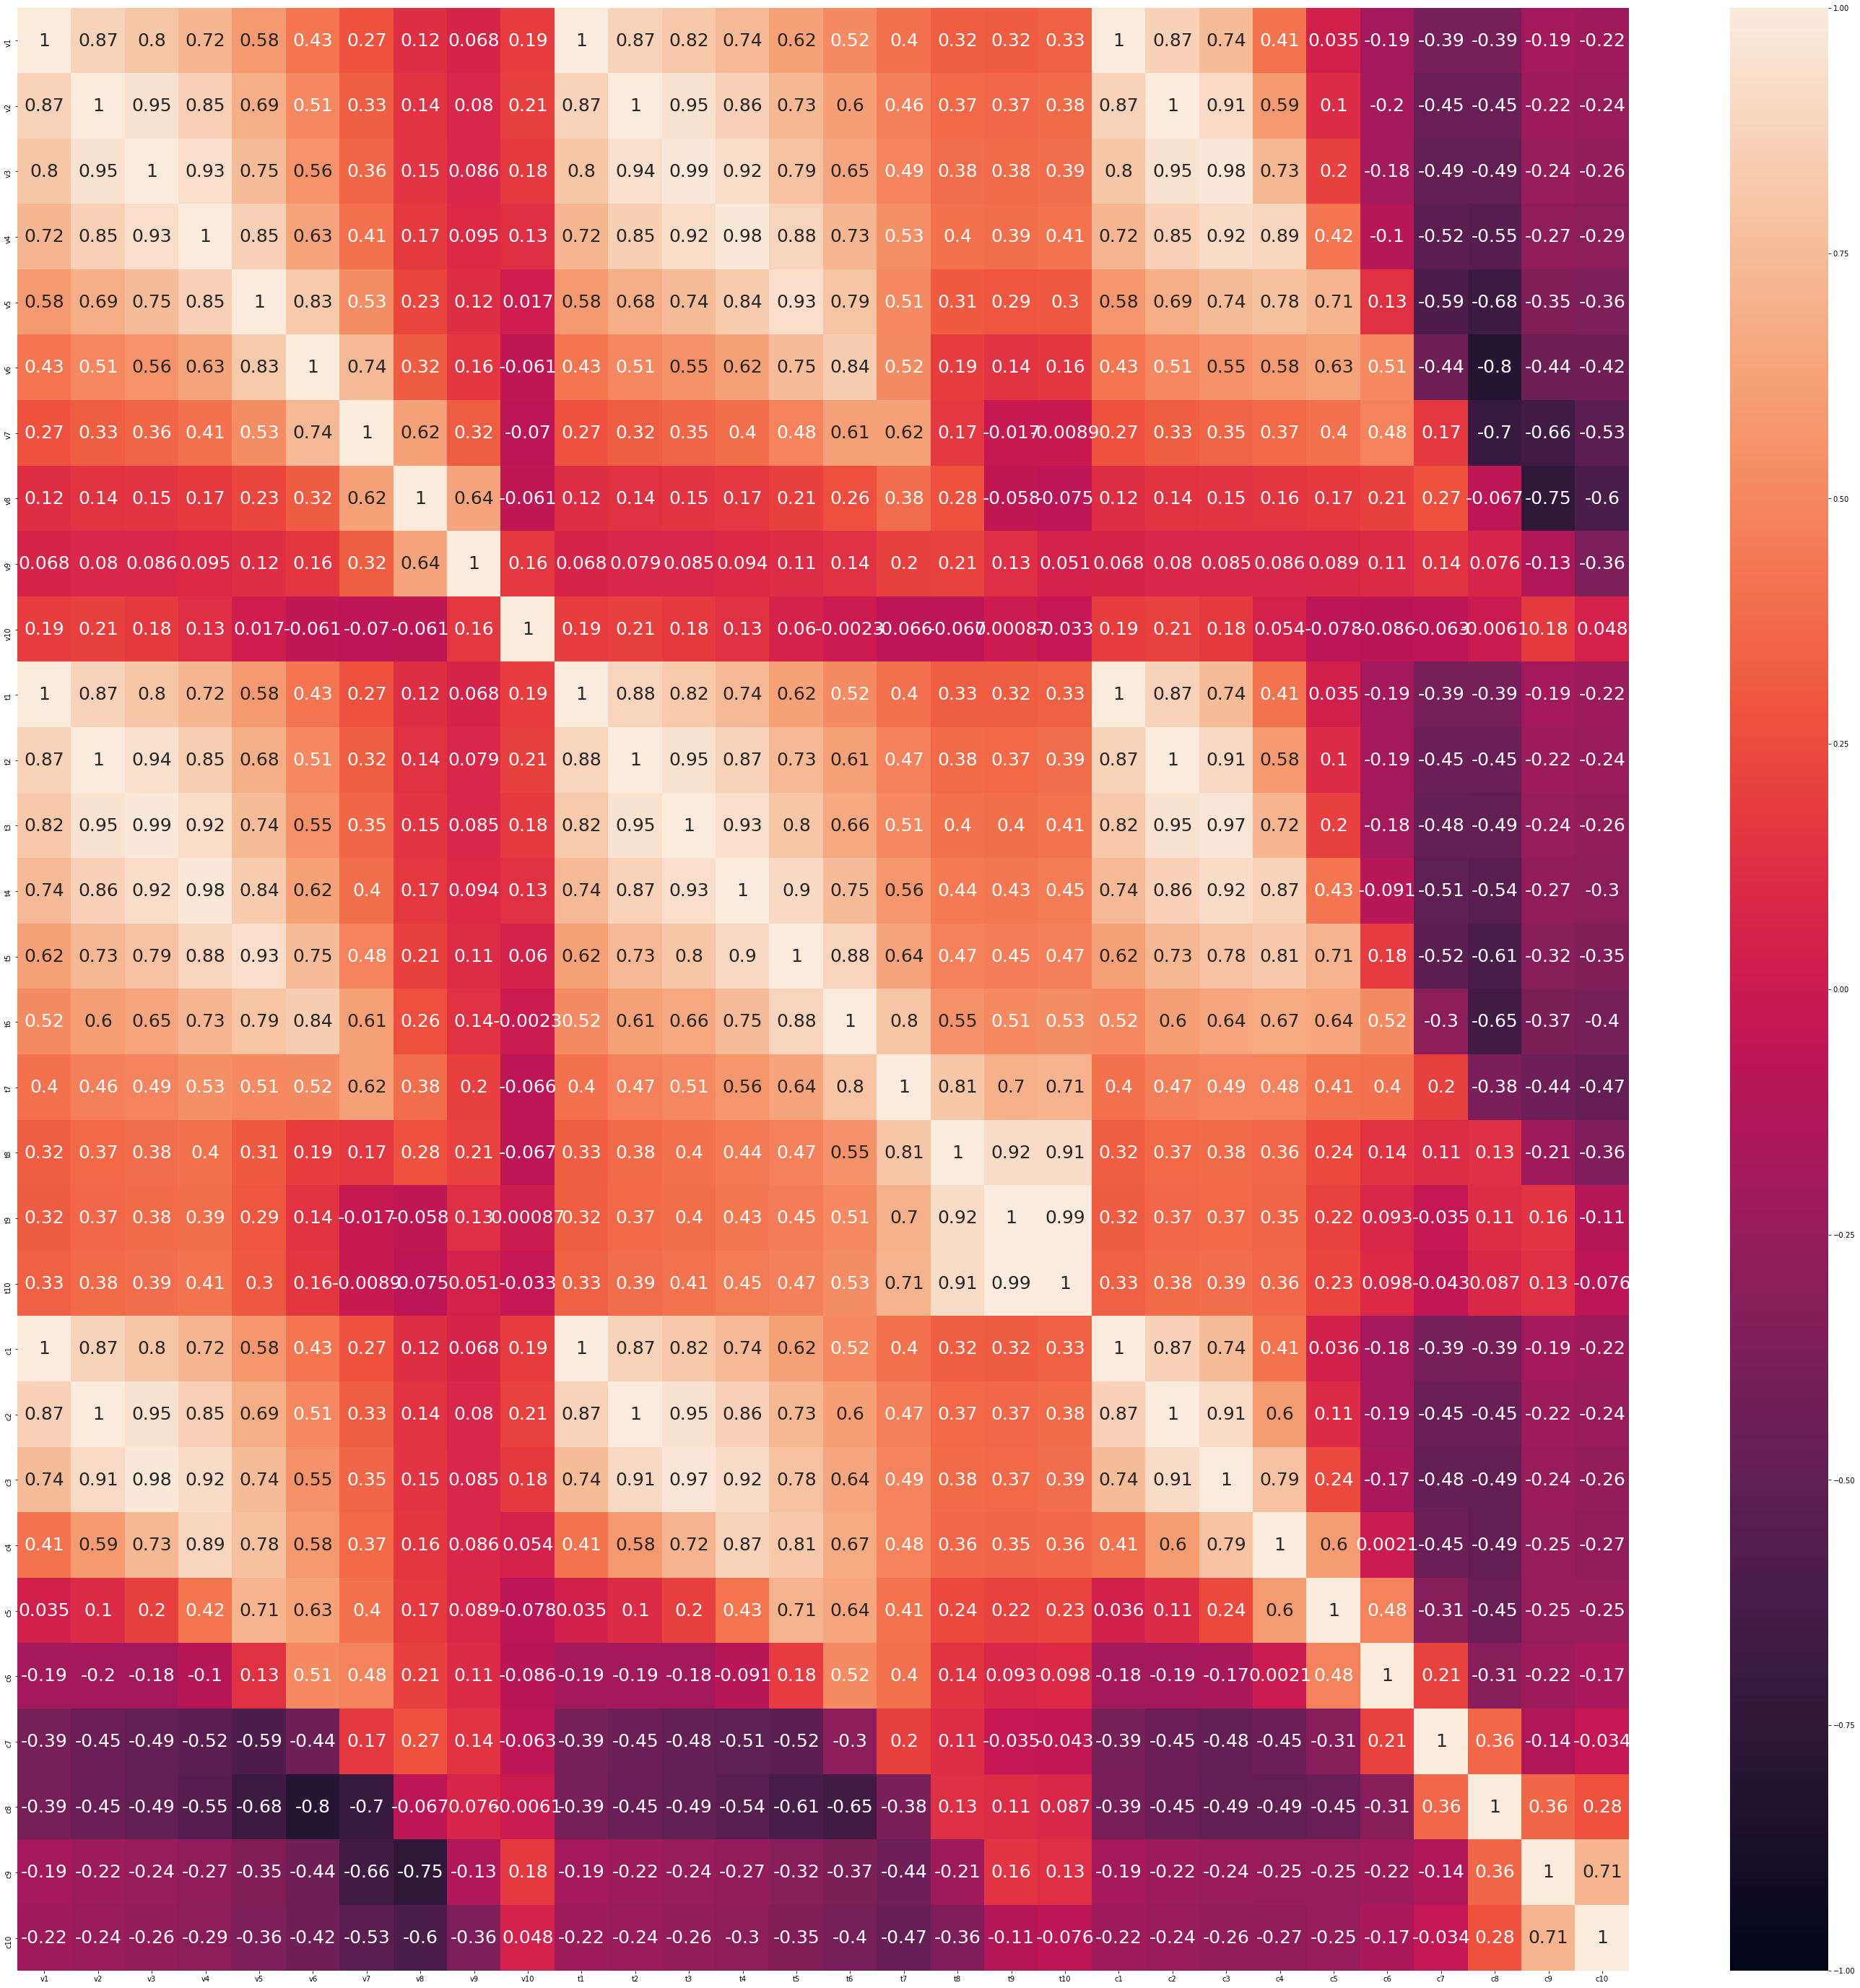

In [3]:
plt.figure(figsize = (50, 50))
#sns.set(font_scale= 3)
res = sns.heatmap(df[df.columns[2:-2]].corr(), annot = True, annot_kws={'size': 25}, vmin = -1, vmax = 1)
#res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 25)
#res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 25)
plt.savefig('seaborn_map')
plt.show()

Observations:
1. It can be seen that there is highcorrelation in features in initial each profile (which is due to padding 0 in each profile)

In [3]:
# Splitting data into train and crossvalidation
x = df[df.columns[1:-2]]
Y = df['soh']
x_train, x_val, Y_train, Y_val = train_test_split(x, Y, train_size = 0.7, shuffle= True)
print('shapes\n')
print('x_train {}, x_val {}'.format(x_train.shape, x_val.shape))

shapes

x_train (1450, 31), x_val (622, 31)


#### Building a Simple mean model to find out performance
Predicted value of mean model is average of target variable (soh)

In [4]:
def average_model(x, y):
    y_mean = np.mean(y)
    y_cap = np.full((len(y),), y_mean)
    rmse = np.sqrt(mean_squared_error(y, y_cap))
    mae = mean_absolute_error(y, y_cap)
    print('Loss for simple mean model\n')
    print('RMSE {} & MAE {}'.format(rmse, mae))
    return 
average_model(x_train, Y_train)

Loss for simple mean model

RMSE 0.23833144481923163 & MAE 0.17166778173625682


__Observation__

Our Random model is giving a RMSE of 0.245 and MAE of 0.179 approx. Therefore we have a rough estimation that metric of our model should be lower then above.

#### Linear Regression

In [5]:
lr = LinearRegression(fit_intercept = True, normalize = False, n_jobs = -1)
lr.fit(x_train, Y_train)
pred = lr.predict(x_train)
print('Train Loss\n')
rmse = np.sqrt(mean_squared_error(Y_train, pred))
mae = mean_absolute_error(Y_train, pred)
print('RMSE {} & MAE {}'.format(rmse, mae))

print('\nValidation Loss\n')
pred_val = lr.predict(x_val)
rmse = np.sqrt(mean_squared_error(Y_val, pred_val))
mae = mean_absolute_error(Y_val, pred_val)
print('RMSE {} & MAE {}'.format(rmse, mae))

Train Loss

RMSE 0.08462001800792165 & MAE 0.04261509117686539

Validation Loss

RMSE 0.09489695870411567 & MAE 0.04708032358336703


#### Ridge Regression

100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 105.24it/s]


Best alpha for corresponding is 0.01


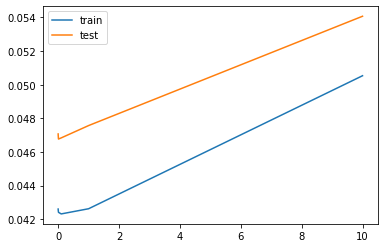

RMSE 0.08468141840806284 & MAE 0.046768696611916315


In [12]:
def ridge(x_train, Y_train, x_val, Y_val):
    alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10]
    RMSE_train_loss = []
    RMSE_val_loss = []
    MAE_train_loss = []
    MAE_val_loss = []
    for ind in tqdm(alpha):
        r = Ridge(alpha =ind)
        r.fit(x_train, Y_train)
        train_pred = r.predict(x_train)
        rmse = np.sqrt(mean_squared_error(Y_train, train_pred))
        mae = mean_absolute_error(Y_train, train_pred)
        RMSE_train_loss.append(rmse)
        MAE_train_loss.append(mae)
        
        val_pred = r.predict(x_val)
        rmse = np.sqrt(mean_squared_error(Y_val, val_pred))
        mae = mean_absolute_error(Y_val, val_pred)
        RMSE_val_loss.append(rmse)
        MAE_val_loss.append(mae)
    print('Best alpha for corresponding is {}'.format(alpha[np.argmin(MAE_val_loss)]))
    plt.plot(alpha, MAE_train_loss, label = 'train')
    plt.plot(alpha, MAE_val_loss, label = 'test')
    plt.legend()
    plt.show()
    
    r_best = Ridge(alpha = alpha[np.argmin(MAE_val_loss)])
    r_best.fit(x_train, Y_train)
    final_pred = r_best.predict(x_train)
    final_val_pred = r_best.predict(x_val)
    rmse = np.sqrt(mean_squared_error(Y_train, final_pred))
    mae = mean_absolute_error(Y_val, final_val_pred)
    print('RMSE {} & MAE {}'.format(rmse, mae))
    pickle.dump(r_best, open('ridge.pkl', 'wb'))
    
ridge(x_train, Y_train, x_val, Y_val) 

#### Lasso Regression

In [ ]:
def lasso(x_train, Y_train, x_val, Y_val):
    alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10]
    RMSE_train_loss = []
    RMSE_val_loss = []
    MAE_train_loss = []
    MAE_val_loss = []
    for ind in tqdm(alpha):
        r = Lasso(alpha =ind, max_iter = 5000)
        r.fit(x_train, Y_train)
        train_pred = r.predict(x_train)
        rmse = np.sqrt(mean_squared_error(Y_train, train_pred))
        mae = mean_absolute_error(Y_train, train_pred)
        RMSE_train_loss.append(rmse)
        MAE_train_loss.append(mae)
        
        val_pred = r.predict(x_val)
        rmse = np.sqrt(mean_squared_error(Y_val, val_pred))
        mae = mean_absolute_error(Y_val, val_pred)
        RMSE_val_loss.append(rmse)
        MAE_val_loss.append(mae)
    print('Best alpha for corresponding is {}'.format(alpha[np.argmin(MAE_val_loss)]))
    plt.plot(alpha, MAE_train_loss, label = 'train')
    plt.plot(alpha, MAE_val_loss, label = 'test')
    plt.legend()
    plt.show()
    
    r_best = Lasso(alpha = alpha[np.argmin(MAE_val_loss)], max_iter = 5000)
    r_best.fit(x_train, Y_train)
    final_pred = r_best.predict(x_train)
    final_val_pred = r_best.predict(x_val)
    rmse = np.sqrt(mean_squared_error(Y_train, final_pred))
    mae = mean_absolute_error(Y_val, final_val_pred)
    print('RMSE {} & MAE {}'.format(rmse, mae))
    
lasso(x_train, Y_train, x_val, Y_val) 

In [34]:
def random_search_svr(df):
    x = df[df.columns[1:-2]]
    y = df['soh']
    svr = SVR()
    param_grid = {'C': loguniform(1e-03, 1e03), 'kernel': ['linear', 'poly', 'rbf'] }
    cv = RandomizedSearchCV(estimator = svr,param_distributions = param_grid ,scoring = 'neg_mean_absolute_error', verbose = True,
                           return_train_score=True, n_jobs = -1, cv = 5, n_iter = 10, random_state = 100)
    cv.fit(x, y)
    print('Best score for SVR is ', -1 * cv.best_score_)
random_search_svr(df)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 13.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001B30B19E988>,
                                        'kernel': ['linear', 'poly', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=100, refit=True,
                   return_train_score=True, scoring='neg_mean_absolute_error',
                   verbose=True)

In [55]:
def random_search_forest(df):
    x = df[df.columns[1:-2]]
    y = df['soh']
    rf = RandomForestRegressor(criterion = 'mae', n_jobs = -1)
    param_grid = {'n_estimators': scipy.stats.randint(1e0, 1e03)}
    cv = RandomizedSearchCV(estimator = rf,param_distributions = param_grid ,scoring = 'neg_mean_absolute_error', verbose = True,
                           return_train_score=True, n_jobs = -1, cv = 5, n_iter = 10, random_state = 100)
    cv.fit(x, y)
    print('Best score for RF is ', -1 * cv.best_score_)
random_search_forest(df)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 75.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 89.2min finished


Best score for SVR is  0.10089094174919926


In [21]:
grid = {'n_estimators': [10, 50, 100, 500, 1000], 'loss' : ['linear', 'square', 'exponential']}
adr = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(criterion = 'mae'))
gcv = GridSearchCV(estimator = adr, param_grid = grid, scoring = 'neg_mean_absolute_error' , n_jobs = -1, return_train_score=True)
gcv.fit(x, Y)
print('Best score for AdaBoost is ', -1 * gcv.best_score_)

Best score for RF is  0.09689270937269076


In [23]:
import xgboost as xgb
grid = {'n_estimators': [50, 100, 500, 1000], 'depth': [10, 100, 500, 1000]}
xg = xgb.XGBRegressor(booster = 'gbtree')
gcv1 = GridSearchCV(estimator = xg, param_grid = grid, scoring = 'neg_mean_absolute_error', n_jobs = -1, return_train_score = True)
gcv1.fit(x, Y)
print('Best score for XGB is ', -1 * gcv1.best_score_)

Best score for XGB is  0.11148057390045499
